In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re


In [3]:
df = pd.read_csv('amazon_alexa.tsv', delimiter= '\t', quoting=3)

print(f"Dataset shape: {df.shape}")

Dataset shape: (3150, 5)


In [4]:
df.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [5]:
df.tail()

,rating,date,variation,verified_reviews,feedback
3145,5,30-Jul-18,Black Dot,"""Perfect for kids, adults and everyone in betw...",1
3146,5,30-Jul-18,Black Dot,"""Listening to music, searching locations, chec...",1
3147,5,30-Jul-18,Black Dot,"""I do love these things, i have them running m...",1
3148,5,30-Jul-18,White Dot,"""Only complaint I have is that the sound quali...",1
3149,4,29-Jul-18,Black Dot,Good,1


In [6]:
df.columns

Index(['rating', 'date', 'variation', 'verified_reviews', 'feedback'], dtype='object')

In [7]:
df.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

In [8]:
df[df['verified_reviews'].isna()== True]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [9]:
df.dropna(inplace=True)

In [10]:
df.shape

(3149, 5)

In [11]:
df['length'] = df['verified_reviews'].apply(len)

In [12]:
df.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [13]:
df.dtypes

rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
length               int64
dtype: object

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3149 entries, 0 to 3149
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3149 non-null   int64 
 1   date              3149 non-null   object
 2   variation         3149 non-null   object
 3   verified_reviews  3149 non-null   object
 4   feedback          3149 non-null   int64 
 5   length            3149 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 172.2+ KB


In [15]:
len(df)

3149

In [16]:
df['rating'].value_counts()

rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64

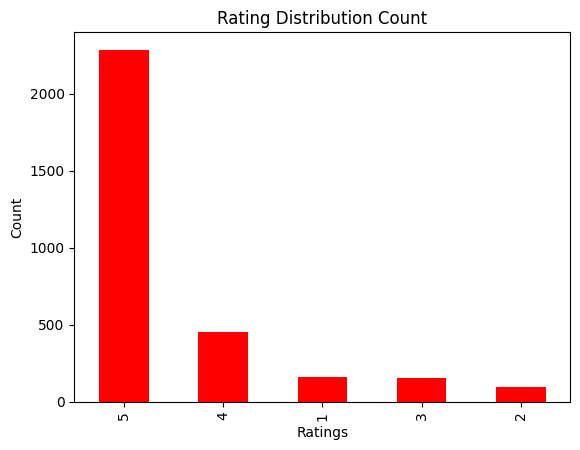

In [17]:
df['rating'].value_counts().plot.bar(color='red')
plt.title('Rating Distribution Count')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

In [18]:
df['rating'].value_counts()/df.shape[0]*100,2

(rating
 5    72.594474
 4    14.449031
 1     5.112734
 3     4.826929
 2     3.016831
 Name: count, dtype: float64,
 2)

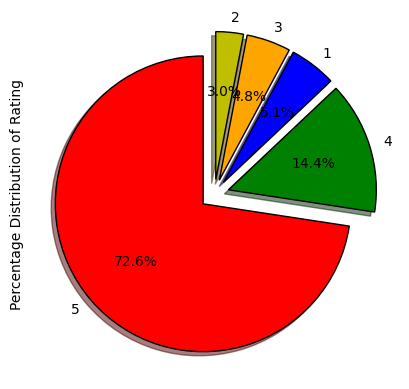

In [19]:
fig=plt.Figure(figsize=(7,7))
colors = ('red', 'g', 'b', 'orange', 'y')
wp = {'linewidth': 1, 'edgecolor': "black"}
tags = df['rating'].value_counts()/df.shape[0]
explode=(0.1,0.1,0.1,.1,.1)
tags.plot(kind="pie", autopct="%1.1f%%", shadow=True, colors=colors,
          startangle=90, wedgeprops=wp, explode=explode, label='Percentage Distribution of Rating')
from io import BytesIO

graph= BytesIO()
fig.savefig(graph, format='png')

In [20]:
df['feedback'].value_counts()

feedback
1    2893
0     256
Name: count, dtype: int64

In [21]:
df[df['feedback'] == 0].iloc[1]['verified_reviews'] 

'Sound is terrible if u want good music too get a bose'

In [22]:
df[df['feedback'] == 1].iloc[1]['verified_reviews'] 

'Loved it!'

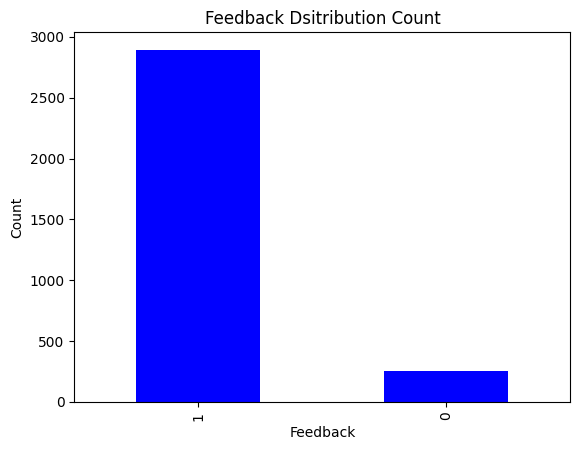

In [23]:
df['feedback'].value_counts().plot.bar(color="blue")
plt.title('Feedback Dsitribution Count')
plt.xlabel('Feedback')
plt.ylabel('Count')
plt.show()

In [26]:
round(df['feedback'].value_counts()/df.shape[0]*100,2)

feedback
1    91.87
0     8.13
Name: count, dtype: float64

<Axes: ylabel='Percentage Distribution of Feedback'>

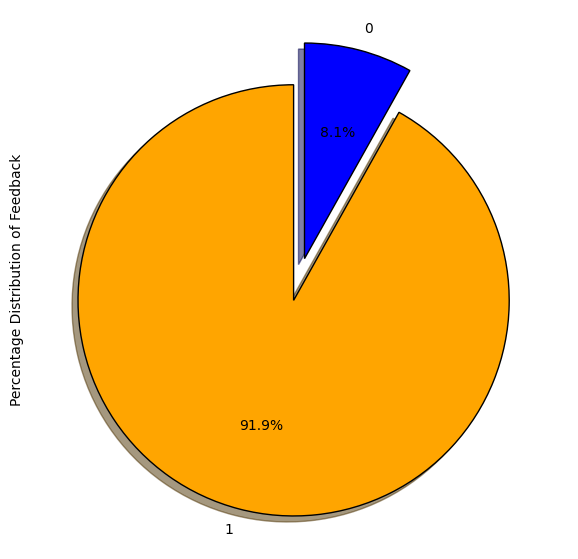

In [27]:
fig = plt.figure(figsize=(7,7))

colors = ('orange', 'blue')

wp = {'linewidth': 1, "edgecolor": 'black'}

tags = df['feedback'].value_counts()/df.shape[0]

explode = (0.1,0.1)

tags.plot(kind="pie", autopct="%1.1f%%", shadow=True, colors=colors,
          startangle=90, wedgeprops=wp, explode=explode, label='Percentage Distribution of Feedback')

In [28]:
df[df['feedback']== 1]['rating'].value_counts()

rating
5    2286
4     455
3     152
Name: count, dtype: int64

In [29]:
df[df['feedback']== 0]['rating'].value_counts()

rating
1    161
2     95
Name: count, dtype: int64

#### if a rating has a review of 1 or 2 then it is negaitive

#### if a rating has a review of 3 4 5 then it is positive

In [30]:
df['variation'].value_counts()

variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
Sandstone Fabric                 90
White                            90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64

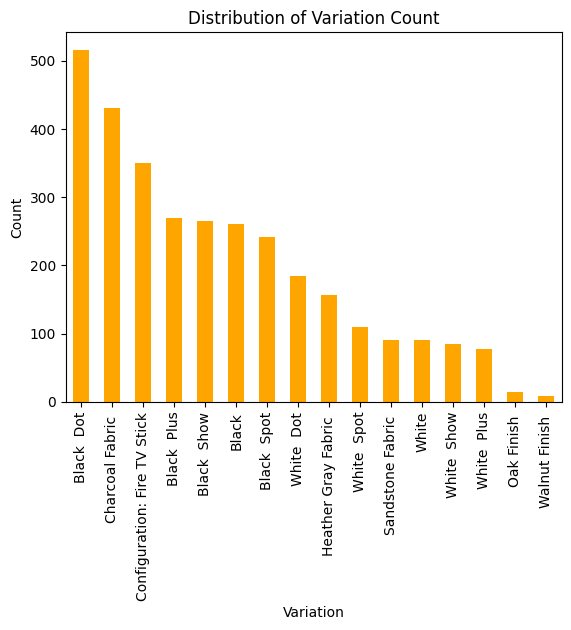

In [32]:
df['variation'].value_counts().plot.bar(color = 'orange')
plt.title('Distribution of Variation Count')
plt.xlabel('Variation')
plt.ylabel('Count')
plt.show()

In [33]:
round(df['variation'].value_counts()/df.shape[0]*100,2)

variation
Black  Dot                      16.39
Charcoal Fabric                 13.66
Configuration: Fire TV Stick    11.11
Black  Plus                      8.57
Black  Show                      8.42
Black                            8.29
Black  Spot                      7.65
White  Dot                       5.84
Heather Gray Fabric              4.99
White  Spot                      3.46
Sandstone Fabric                 2.86
White                            2.86
White  Show                      2.70
White  Plus                      2.48
Oak Finish                       0.44
Walnut Finish                    0.29
Name: count, dtype: float64

<Axes: xlabel='variation'>

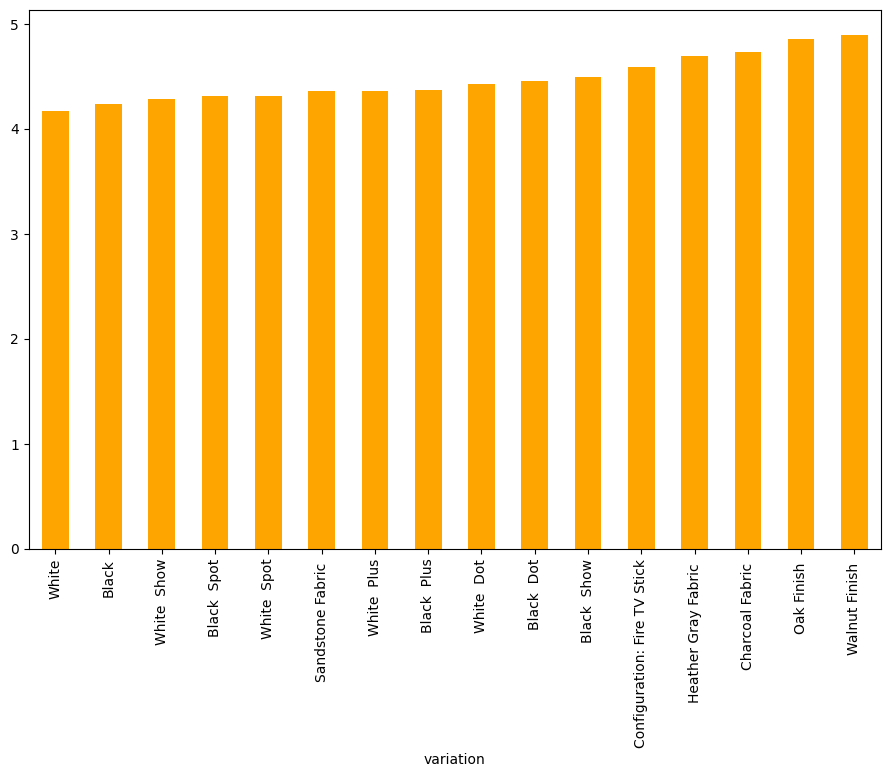

In [35]:
df.groupby('variation')['rating'].mean().sort_values().plot.bar(color = 'orange', figsize = (11,7))

In [36]:
df['length'].describe()

count    3149.000000
mean      132.714513
std       182.541531
min         1.000000
25%        30.000000
50%        74.000000
75%       166.000000
max      2853.000000
Name: length, dtype: float64

[Text(0.5, 1.0, 'Dsitribution of length of review')]

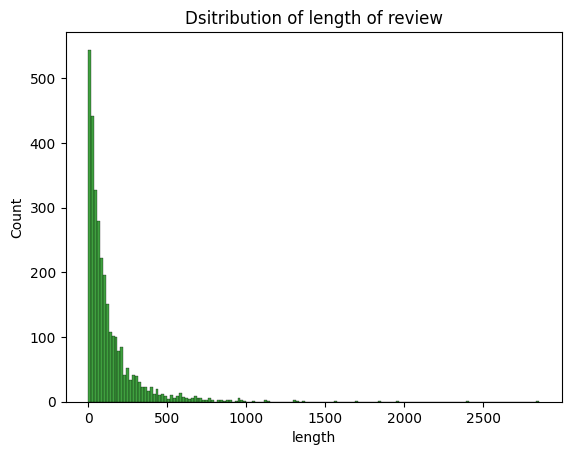

In [38]:
sns.histplot(df['length'], color='green').set(title="Dsitribution of length of review")

[Text(0.5, 1.0, 'Distribution of length of review if  feedback = 0')]

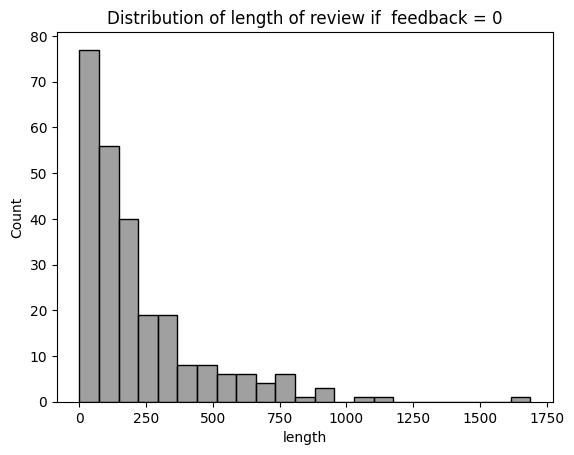

In [39]:
sns.histplot(df[df['feedback']==0]['length'],color='gray').set(title='Distribution of length of review if  feedback = 0')

[Text(0.5, 1.0, 'Distribution of length of review if  feedback = 1')]

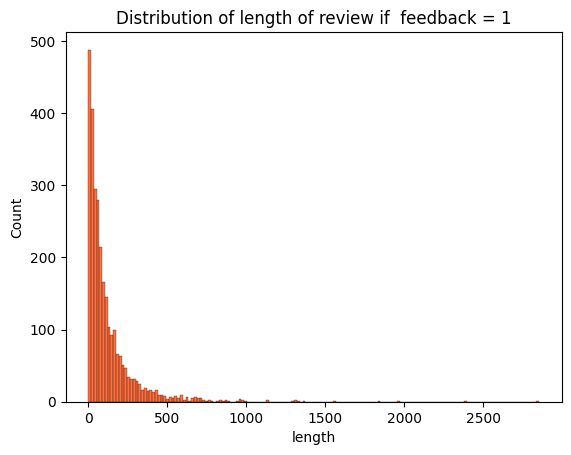

In [47]:
sns.histplot(df[df['feedback']==1]['length'],color='#ff4200').set(title='Distribution of length of review if  feedback = 1')

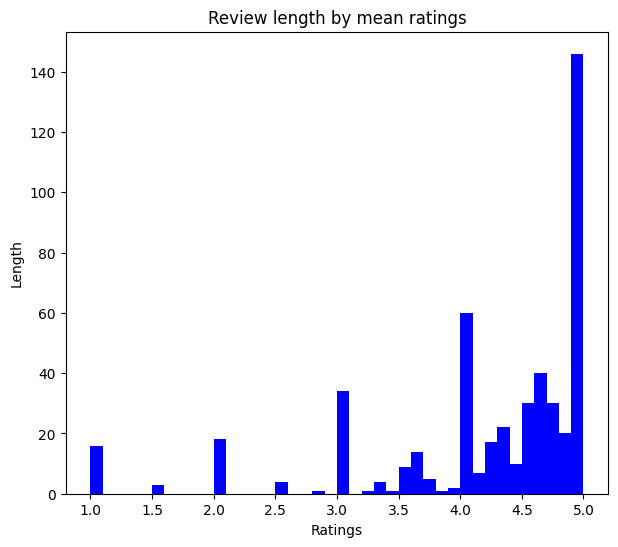

In [49]:
df.groupby('length')['rating'].mean().plot.hist(color= 'blue', figsize=(7,6), bins =40)
plt.title('Review length by mean ratings')
plt.xlabel('Ratings')
plt.ylabel('Length')
plt.show()

In [50]:
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(df.verified_reviews)

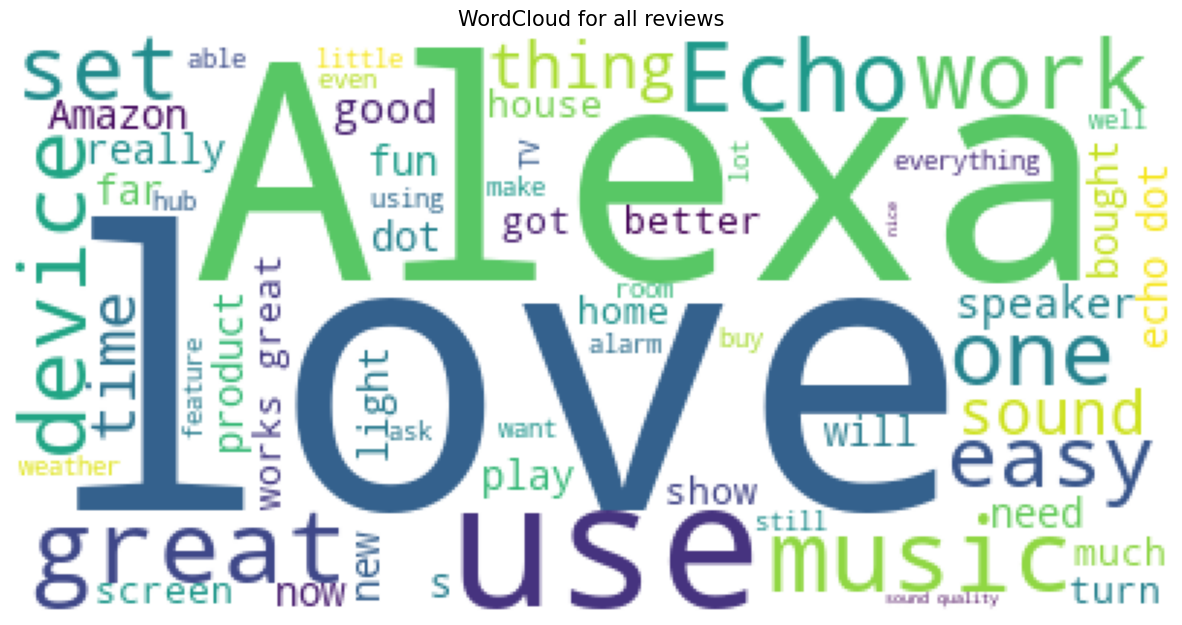

In [56]:
reviews = ''.join([review for review in df['verified_reviews']])

wc = WordCloud(background_color='white', max_words=60)

plt.figure(figsize= (15,15))
plt.imshow(wc.generate(reviews))
plt.title("WordCloud for all reviews", fontsize=15)
plt.axis('off')
plt.show()

In [58]:
neg_reviews = " ".join([review for review in df[df['feedback']==0]['verified_reviews']])
neg_reviews = neg_reviews.lower().split()

pos_reviews =  " ".join([review for review in df[df['feedback']==1]['verified_reviews']])
pos_reviews = pos_reviews.lower().split()

unique_neg = [x for x in neg_reviews if x not in pos_reviews]
unique_neg = ' '.join(unique_neg)

unique_pos = [x for x in pos_reviews if x not in neg_reviews]
unique_pos = ' '.join(unique_pos)


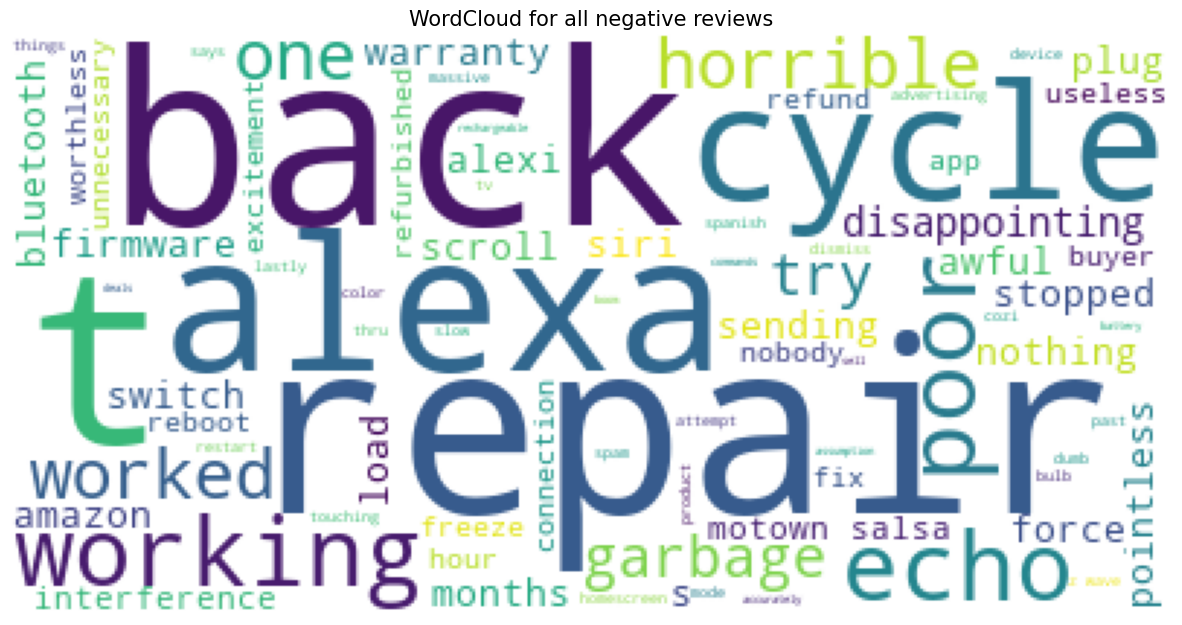

In [59]:
wc = WordCloud(background_color='white', max_words=80)

plt.figure(figsize= (15,15))
plt.imshow(wc.generate(unique_neg))
plt.title("WordCloud for all negative reviews", fontsize=15)
plt.axis('off')
plt.show()

Negative words here include garbage,poor,echo, pointless, awful, disappointing, repair, etc

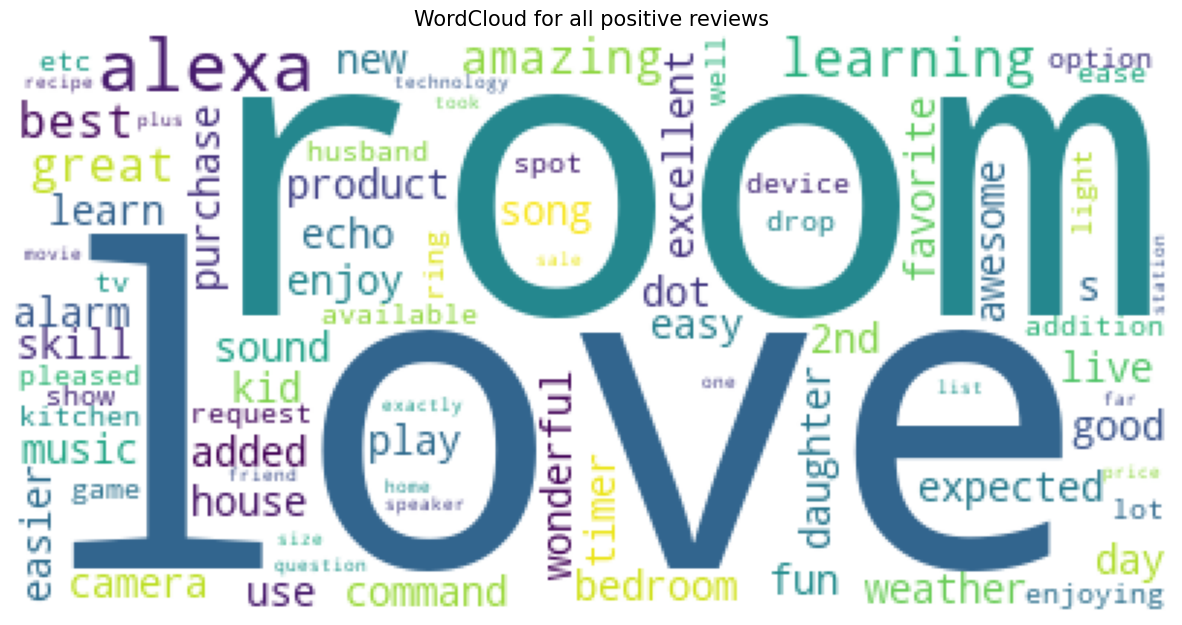

In [60]:
wc = WordCloud(background_color='white', max_words=80)

plt.figure(figsize= (15,15))
plt.imshow(wc.generate(unique_pos))
plt.title("WordCloud for all positive reviews", fontsize=15)
plt.axis('off')
plt.show()

Positive words include love, enjoying, fun, wonderful, easier, amazing, excellent, awesome

## Preprocessing and Modelling

In [62]:
corpus = []
stemmer = PorterStemmer()
for i in range(0, df.shape[0]):
    review = re.sub('[^a-zA-Z]', ' ', df.iloc[i]['verified_reviews'])
    review = review.lower().split()
    review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
    review = ' '.join(review)
    corpus.append(review)

In [63]:
cv = CountVectorizer(max_features=2500)

x = cv.fit_transform(corpus).toarray()
y = df['feedback'].values

In [66]:
pickle.dump(cv, open('countVectorizer.pkl', 'wb'))

In [68]:
x.shape

(3149, 2500)

In [69]:
y.shape

(3149,)

In [70]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=15)

In [72]:
x_train.shape

(2204, 2500)

In [73]:
x_test.shape

(945, 2500)

In [74]:
x_train.max()

12

In [75]:
x_test.max()

10

In [76]:
scaler = MinMaxScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [78]:
pickle.dump(scaler, open('scaler.pkl', 'wb'))

### Random Forest

In [79]:
rf = RandomForestClassifier()
rf.fit(x_train_scaled, y_train)

RandomForestClassifier()

In [80]:
rf.score(x_train_scaled, y_train)

0.9945553539019963

In [81]:
rf.score(x_test_scaled, y_test)

0.9439153439153439

In [82]:
y_preds = rf.predict(x_test_scaled)

In [83]:
cm = confusion_matrix(y_test, y_preds)

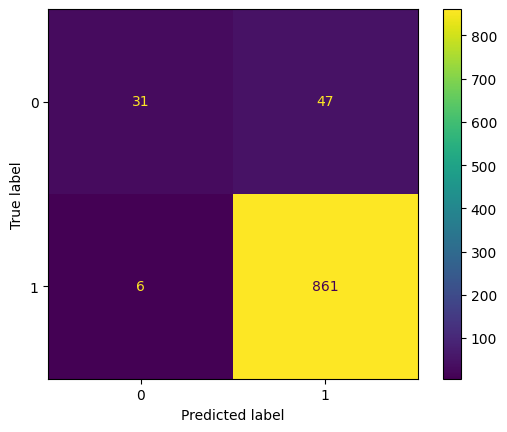

In [86]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=rf.classes_)
cm_display.plot()
plt.show()

In [91]:
accuracies  = cross_val_score(estimator= rf, X = x_train_scaled, y = y_train, cv =10)

print('Accuracy:  ',{accuracies.mean()})

Accuracy:   {0.9310366104483752}


In [92]:
params = {
    'bootstrap': [True],
    'max_depth': [80, 100],
    'min_samples_split': [8,12],
    'n_estimators': [100,300]
}

In [93]:
cv_object = StratifiedKFold(n_splits=2)

grid_search = GridSearchCV(estimator= rf, param_grid=params,
                           cv = cv_object, verbose=0, return_train_score=True)
grid_search.fit(x_train_scaled, y_train.ravel())

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [80, 100],
                         'min_samples_split': [8, 12],
                         'n_estimators': [100, 300]},
             return_train_score=True)

In [94]:
print('Best Parameter Combination: {}'.format(grid_search.cv_results_['mean_train_score'].mean()*100))
print('Cross Validation mean accuracy on test set : {}'.format(grid_search.cv_results_['mean_test_score'].mean()*100))
print('Accuracy Score for test set: ', accuracy_score(y_test, y_preds))

Best Parameter Combination: 96.81828493647913
Cross Validation mean accuracy on test set : 92.14496370235933
Accuracy Score for test set:  0.9439153439153439


## XGBoost

In [96]:
xgb = XGBClassifier()
xgb.fit(x_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [97]:
xgb.score(x_train_scaled, y_train)

0.971415607985481

In [98]:
xgb.score(x_test_scaled, y_test)

0.9417989417989417

In [99]:
y_preds_xgb = xgb.predict(x_test)

In [102]:
cm  = confusion_matrix(y_test, y_preds_xgb)
cm

array([[ 31,  47],
       [ 13, 854]], dtype=int64)

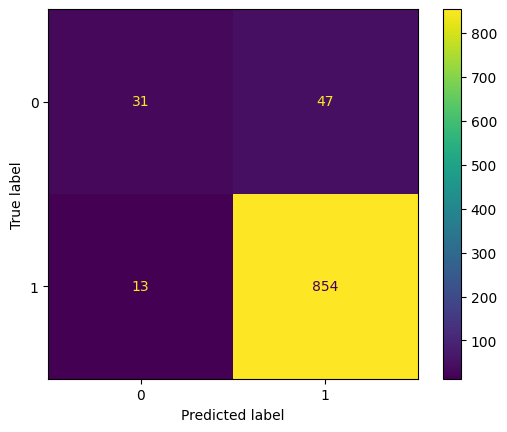

In [103]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=xgb.classes_)
cm_display.plot()
plt.show()

In [104]:
pickle.dump(xgb, open('xgb.pkl', 'wb'))